# Galaxy vs. quasars

#### Tasks

The dataset is at `solutions/galaxyquasar.csv` (I extracted it from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors))

- First, read the datafile.
- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

##### Food for thought
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?



In [1]:
import numpy as np
from matplotlib import pyplot as plt
import csv
from astroML.classification import GMMBayes
from astroML.utils import split_samples, completeness_contamination
import corner
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNC


Collect tha data and prepare the colors

In [2]:
u=[]
g=[]
r=[]
i=[]
z=[]
clas=[]
z1=[]
zerr=[]

with open('/Users/federicoastori/Desktop/ilovegit/WORK_19/galaxyquasar.csv', mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        u.append(float(row["u"]))
        g.append(float(row["g"]))
        r.append(float(row["r"]))
        i.append(float(row["i"]))
        z.append(float(row["z"]))
        clas.append((row["class"]))
        z1.append(float(row["z1"]))
        zerr.append(float(row["zerr"]))
        #print(f'\t{row["u"]} , {row["g"]} , {row["r"]} , {row["i"]} , {row["z"]} , {row["class"]} , {row["z1"]} , {row["zerr"]}')
        line_count += 1
    print(f'Processed {line_count} lines.')
    
labels=[]

for label in clas:
    if label=='QSO':
        labels.append(1)
    else:
        labels.append(0)

u = np.array(u)
g = np.array(g)
r = np.array(r)
i = np.array(i)
z = np.array(z)
clas = np.array(clas)
z1 = np.array(z1)
zerr = np.array(zerr)
labels = np.array(labels)

        
u_g = u - g
g_r = g - r
r_i = r - i
i_z = i - z


Column names are u, g, r, i, z, class, z1, zerr
Processed 50001 lines.


Adopting the sklearn nomenclature I build the data and the labels which I use to produce the training and test sets.

Just to visualize the colors result I make a corner plot, where is visible a bimodality in the u_g color

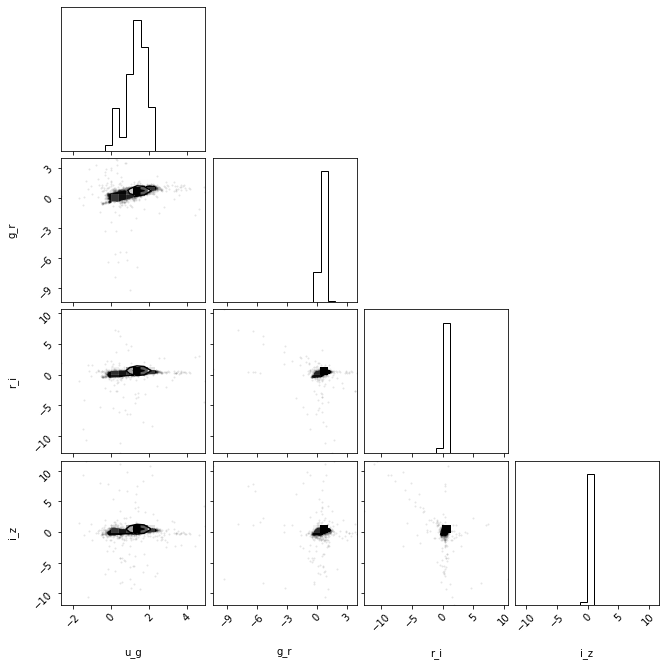

In [6]:

X=np.array([u_g,g_r,r_i,i_z]).T
y = labels

corner.corner(X,labels=['u_g','g_r','r_i','i_z'] )

X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results

(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.70, 0.30], random_state=42)



Let me implement the different algorithms to perform supervised classification. Starting from that with the larger number of assumption and concluding with that who relax all of them. I also plot the ROC curve and completness vs contamination plot to understand how the number of colors influence the classification.

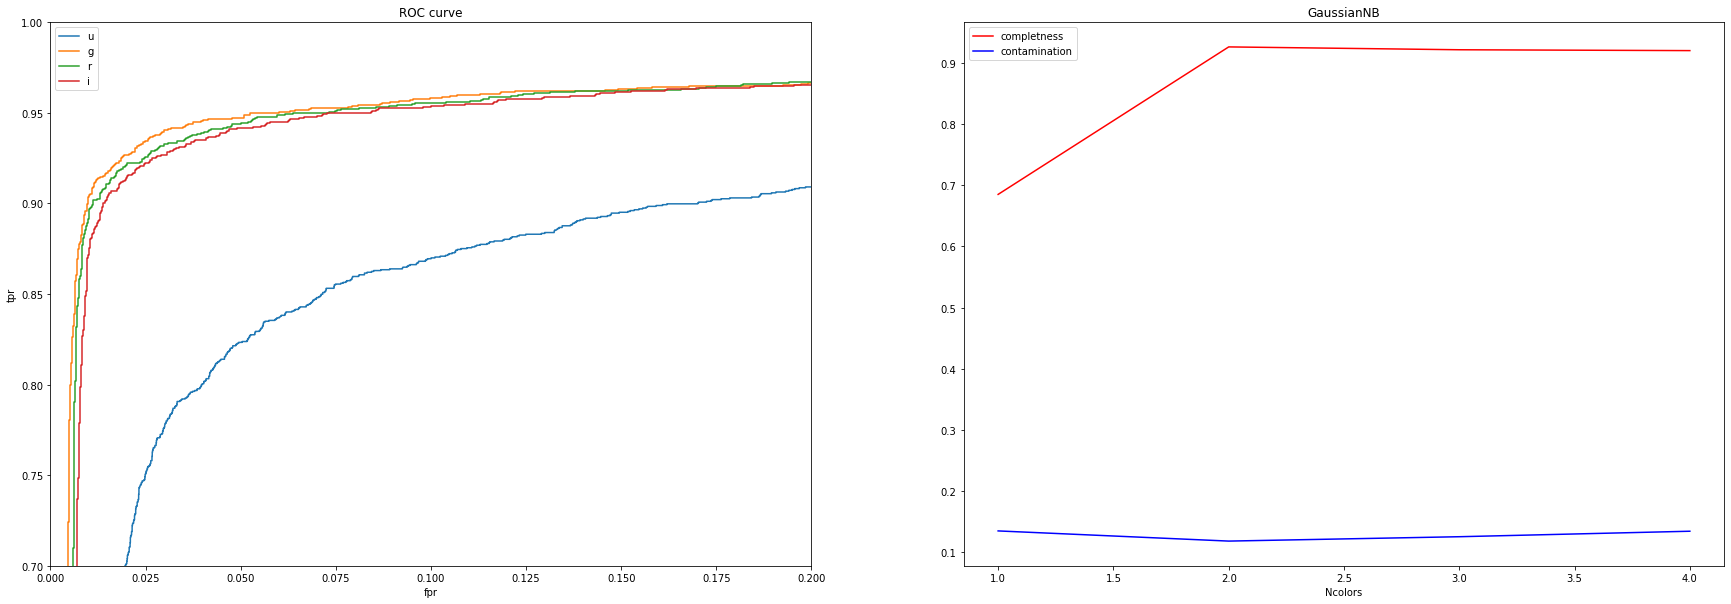

In [45]:
# Gaussian Naive Bayes

Ncolors = np.arange(1,5,1)
y_prob = np.array([])
classifiers=[]
predictions=[]

c=['u','g','r','i','z']

plt.figure(figsize=(30,10))
for nc in Ncolors:
    clf = GaussianNB()
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])
    
    y_prob = clf.predict_proba(X_test[:, :nc])[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    
    classifiers.append(clf)
    predictions.append(y_pred)
    
    
    plt.subplot(121)
    plt.title('ROC curve')
    plt.plot(fpr,tpr,label=c[nc-1])
    plt.xlabel('fpr') # false positive rate
    plt.ylabel('tpr')
    plt.xlim(0,0.2)
    plt.ylim(0.7,1)
    plt.legend(loc=0)
    
    
   
completeness, contamination = completeness_contamination(predictions, y_test)

plt.subplot(122)
plt.title('GaussianNB')
plt.plot(Ncolors,completeness,'-r', label='completness')
plt.plot(Ncolors,contamination,'-b',label='contamination')
plt.xlabel('Ncolors')
plt.legend(loc=0)

#print("completeness", completeness)
#print("contamination", contamination)



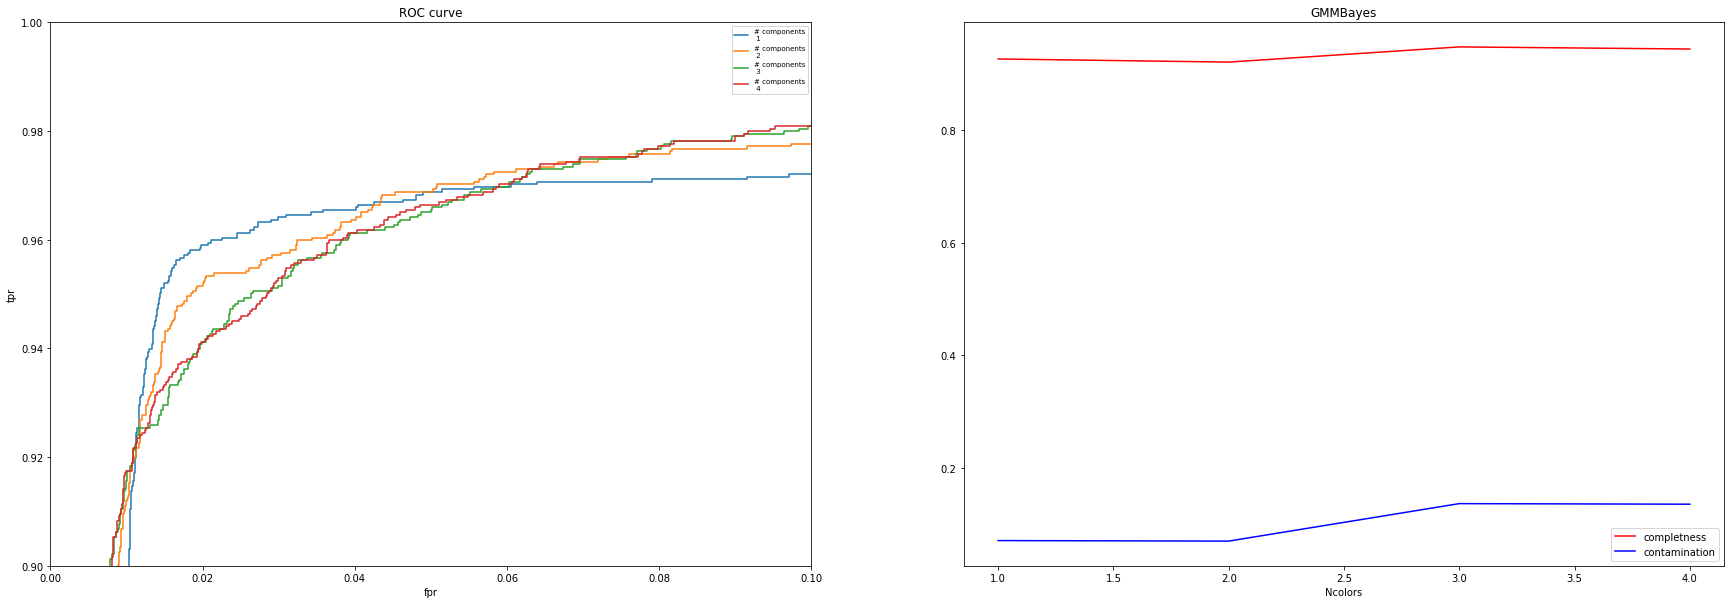

In [13]:
classifiers=[]
predictions=[]

#  GMMBayes

plt.figure(figsize=(30,10))
for nc in Ncolors:
    clf = GMMBayes(nc)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test[:,:4])
    
    y_prob = clf.predict_proba(X_test[:,:4])[:,1]
    
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    
    predictions.append(y_pred)
    
    plt.subplot(121)
    plt.plot(fpr,tpr,label='# components\n %1.0f' %(nc))
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('ROC curve')
    plt.xlim(0,0.1)
    plt.ylim(0.9,1)
    plt.legend(loc=0, fontsize='x-small')
    
completeness, contamination = completeness_contamination(predictions, y_test)

plt.subplot(122)
plt.title('GMMBayes')
plt.plot(Ncolors,completeness,'-r', label='completness')
plt.plot(Ncolors,contamination,'-b',label='contamination')
plt.xlabel('Ncolors')
plt.legend(loc=0)



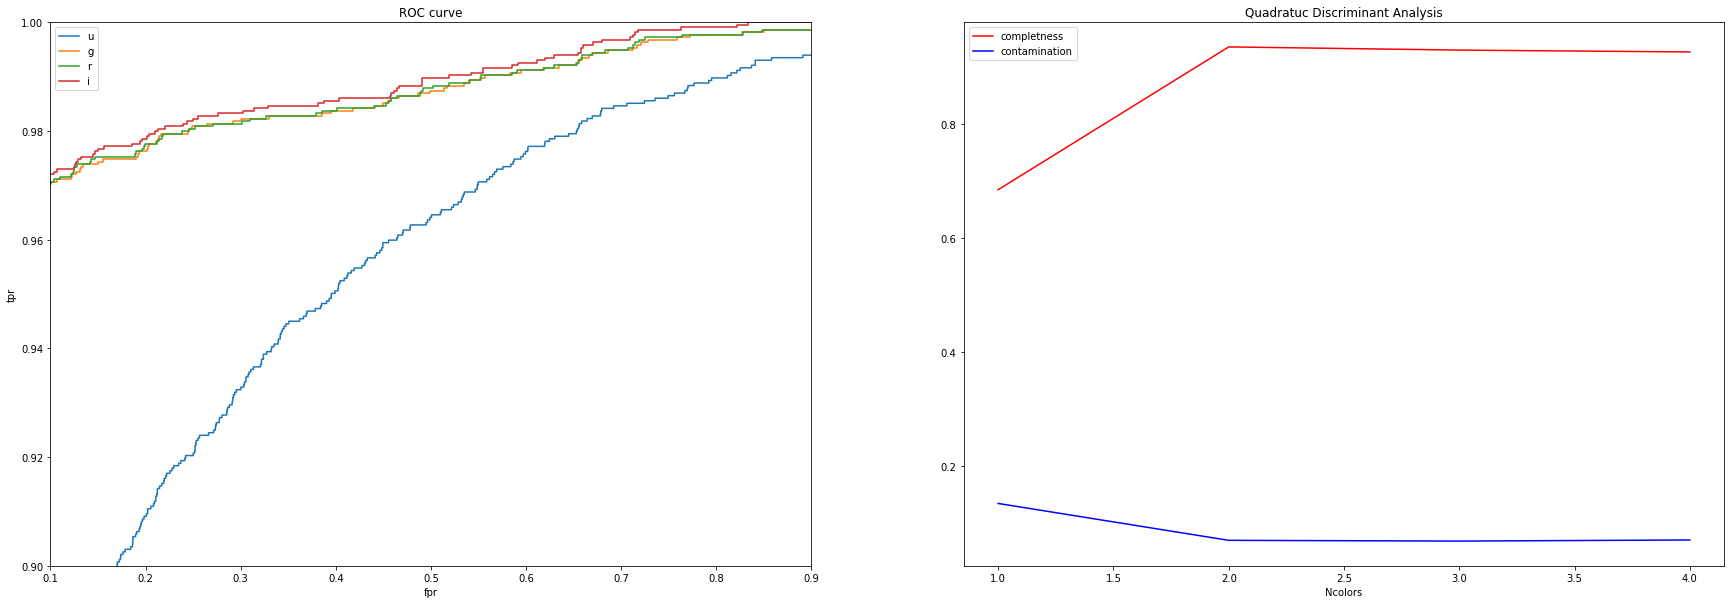

In [19]:
classifiers=[]
predictions=[]

# quadratic discriminant analysis


plt.figure(figsize=(30,10))
for nc in Ncolors:
    clf = QDA()
    clf.fit(X_train[:,:nc],y_train)
    y_pred = clf.predict(X_test[:,:nc])
    
    y_prob = clf.predict_proba(X_test[:,:nc])[:,1]
    
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    
    predictions.append(y_pred)
    
    plt.subplot(121)
    plt.plot(fpr,tpr,label=c[nc-1])
    plt.xlabel('fpr') 
    plt.ylabel('tpr')
    plt.title('ROC curve')
    plt.xlim(0.1,0.9)
    plt.ylim(0.9,1)
    plt.legend(loc=0)
    
completeness, contamination = completeness_contamination(predictions, y_test)

plt.subplot(122)
plt.title('Quadratuc Discriminant Analysis')
plt.plot(Ncolors,completeness,'-r', label='completness')
plt.plot(Ncolors,contamination,'-b',label='contamination')
plt.xlabel('Ncolors')
plt.legend(loc=0)

y_pred_qda = y_pred

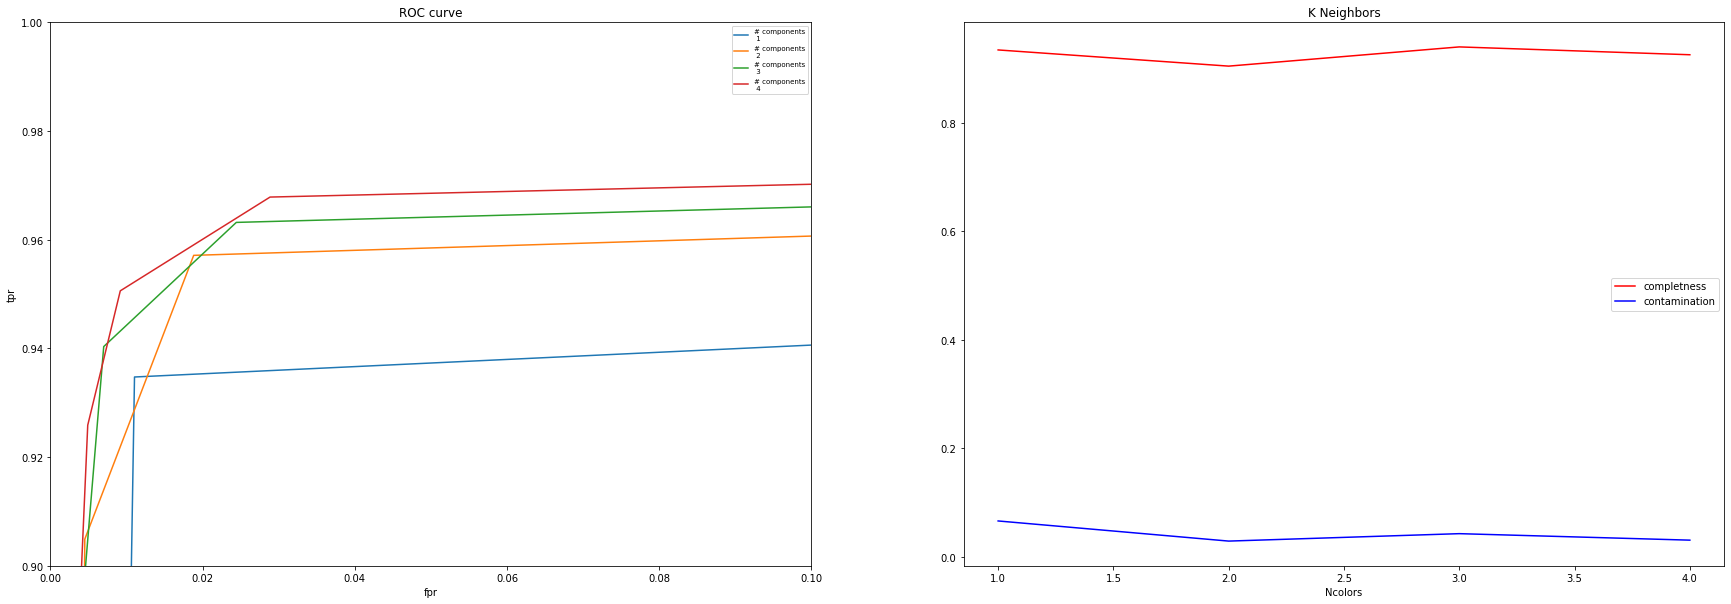

In [11]:
# K neighbrs

classifiers=[]
predictions=[]

plt.figure(figsize=(30,10))
for nc in Ncolors:
    clf = KNC(nc)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test[:,:4])
    
    y_prob = clf.predict_proba(X_test[:,:4])[:,1]
    
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    
    predictions.append(y_pred)
    
    plt.subplot(121)
    plt.plot(fpr,tpr,label='# components\n %1.0f' %(nc))
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('ROC curve')
    plt.xlim(0,0.1)
    plt.ylim(0.9,1)
    plt.legend(loc=0, fontsize='x-small')
    
completeness, contamination = completeness_contamination(predictions, y_test)

plt.subplot(122)
plt.title('K Neighbors')
plt.plot(Ncolors,completeness,'-r', label='completness')
plt.plot(Ncolors,contamination,'-b',label='contamination')
plt.xlabel('Ncolors')
plt.legend(loc=0)


I use QDA prediction since the ROC curve present the larger area per decision boundry. Than I compare prediction and rigth result. We can see that the bimodality is preserved, as well as the distributions

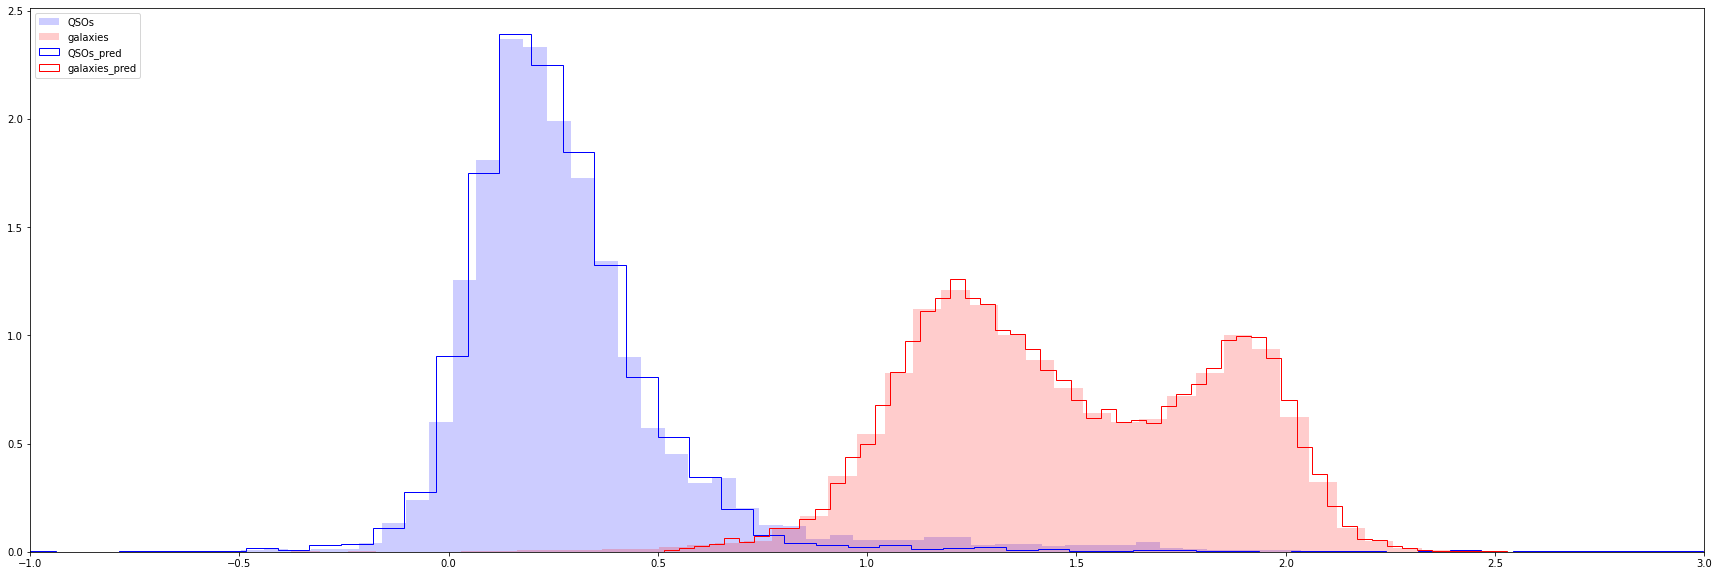

In [43]:
# PART 2

clf = QDA()
clf.fit(X_train[:,:4],y_train)
y_pred_QDA = clf.predict(X[:,:4])

# bimodaliy in u_g
'''
plt.figure()
plt.hist(u,bins=100, density=True, histtype='step', color='blue')
plt.hist(g,bins=100,density=True, histtype='step', color='green')

plt.hist(u_g,bins=100,density=True, histtype='step', color='red')
'''

plt.figure(figsize=(30,10))
plt.hist(u_g[labels==1],bins=100, density=True, histtype='stepfilled', color='blue', label='QSOs', alpha=0.2)
plt.hist(u_g[labels==0],bins=100, density=True, histtype='stepfilled', color='red', label='galaxies', alpha=0.2)


plt.hist(u_g[y_pred_QDA==1],bins=100, density=True, histtype='step', color='blue', label='QSOs_pred')
plt.hist(u_g[y_pred_QDA==0],bins=100, density=True, histtype='step', color='red', label='galaxies_pred')

plt.xlim(-1,3)

plt.legend(loc=0)